### Importing Packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import seaborn as sns
from math import sqrt
sns.set()
import warnings
warnings.filterwarnings("ignore")

### Loading & Transforming Data

In [6]:
raw_csv_data = pd.read_csv("Index2018.csv")
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace = True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method = 'ffill')

### Removing Surplus Data

In [7]:
df_comp['market_value'] = df_comp.ftse

In [8]:
del df_comp['spx'],df_comp['dax'],df_comp['ftse'],df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [9]:
df['returns'] = df.market_value.pct_change(1).mul(100)
df = df.iloc[1:]

### LLR Test

In [10]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

### Moving Average (MA) Model
<img src = Images/MA.png>

#### `Mean of Et = 0
#### Variance of Et = constant`


### Simple MA Model
<img src = "Images/MA-model.png">

### How do we generate Residuals?
<img src = Images/res.png>

### MA & AR Relationship
<img src = "Images/MA&AR.png">

<img src = "Images/MAAR.png">

##### NOTE - The only major difference is that the AR model uses the value of the variable while the MA model relies on the residual. 


Finally, there's one more common trait of the AR and MA models, the restriction remains that the `absolute value of each coefficient should be less than one`. This is to prevent `compounded effects exploding in magnitude`

### AR vs MA Model

<img src = "Images/ARvsMA.png">

##### NOTE - The reason is the `MA models aren't based on past period returns`, therefore, determining which lagged values have a significant direct effect on the present day ones is not relevant.

#### The total accumulated effects accommodate for these unexpected shocks, hence the ACF plot provides us with information on how many lags our model should use.

### ACF for Returns

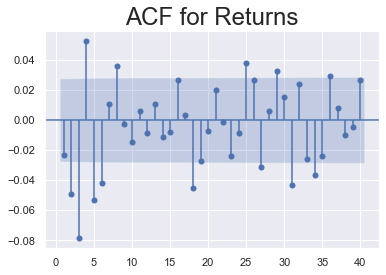

In [11]:
sgt.plot_acf(df.returns, zero = False, lags = 40)
plt.title("ACF for Returns", size = 24)
plt.show()

### MA(1) for Returns

<img src = "Images/MA(1).png">

<img src = "Images/AR-MA.png">

In [12]:
model_ret_ma_1 = ARMA(df.returns[1:], order = (0,1))
results_ret_ma_1 = model_ret_ma_1.fit()
results_ret_ma_1.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57970D+00    |proj g|=  1.26565D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   2.220D-08   1.580D+00
  F =   1.5796974108407174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                     ARMA(0, 1)   Log Likelihood               -7928.501
Method:                       css-mle   S.D. of innovations              1.174
Date:                Fri, 21 Jan 2022   AIC                          15863.003
Time:                        01:16:53   BIC                          15882.566
Sample:                    01-11-1994   HQIC                         15869.858
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.165      0.244      -0.013       0.050
ma.L1.returns    -0.0258      0.015     -1.721      0.085      -0.055       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           38.8133           +0.0000j           38.8133            0.0000
-----------------------------------------------------------------------------
"""

<img src = "Images/summary.png">

You can notice that the coefficient for the one lag ago residual is significant at the 10 percent level, but not at the 5 % level. This shouldn't come as a surprise since the first coefficient of the ACF was also not `significantly different from zero.` However, all other coefficients up to six lags ago fell outside the blue area, which suggests significance. 

In addition, the `8th` and the `18th` lag, were also significant, as were some others, more than 20 periods ago. Since we expect the `compound effects to decrease the further back in time we go`, we can `disregard the 18th lag` and all significant periods that follow it. That's because `we expect their impact on today's returns to be minimal.` Moreover, we should also check `whether we should add the eighth lag as a worthwhile significance` or `we should select one of the simpler models.`

In [13]:
model_ret_ma_2 = ARMA(df.returns[1:], order = (0,2))
results_ret_ma_2 = model_ret_ma_2.fit()
print(results_ret_ma_2.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_1, model_ret_ma_2)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57835D+00    |proj g|=  2.62013D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   0.000D+00   1.578D+00
  F =   1.5783543259649924     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5019
Model:                     ARMA(0, 2

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   0.000D+00   1.578D+00
  F =   1.5783543259649924     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

LLR test p-value = 0.0


##### NOTE - Now all the P values are significant since all values are less than 0.05. Therefore, we can say `MA(2) > MA(1)`, but we still need to run the LLR test for the same to confirm.

#### Since LLR test p-value = 0.0, this means the `MA(2) makes significantly better predictions.`

In [14]:
model_ret_ma_3 = ARMA(df.returns[1:], order = (0,3))
results_ret_ma_3 = model_ret_ma_3.fit()
print(results_ret_ma_3.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_2, model_ret_ma_3)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57466D+00    |proj g|=  1.20348D-05

At iterate    5    f=  1.57466D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   4.441D-08   1.575D+00
  F =   1.5746591726874823     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5019
Model:                     ARMA(0, 3)   Log Likelihood               -7903.214
Method:                       css-mle   S.D. of innovations              1.168
Date:                Fri, 21 Jan 2022   AIC                          15816.429
Time:                        01:16:53   BIC                          15849.034
Sample:                    01-11-1994   HQIC                         15827.854
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.014      1.379      0.168      -0.008       0.046
ma.L1.returns    -0.0203      0.014     -1.425      0.154      -0.048       0.008
ma.L2.returns    -0.0557      0.013     

 This problem is unconstrained.


#### The new coefficient (ma.L3.returns) has a P value of zero, which makes it significant. The same can also be said about the second lag, but not the first. Since the ACF suggests the first period coefficient should not be significant, we can predict that the correct model will have a high P value for one period ago error term. 

#### Since LLR test p-value = 0.0, this means the `MA(3) makes significantly better predictions.`

In [15]:
model_ret_ma_4 = ARMA(df.returns[1:], order = (0,4))
results_ret_ma_4 = model_ret_ma_4.fit()
print(results_ret_ma_4.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_3, model_ret_ma_4)))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57355D+00    |proj g|=  1.27232D-05

At iterate    5    f=  1.57355D+00    |proj g|=  6.66134D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   2.220D-08   1.574D+00
  F =   1.5735516938290086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                              ARMA Model Results                              
Dep. Variable:                returns   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.



LLR test p-value = 0.001


In [16]:
model_ret_ma_5 = ARMA(df.returns[1:], order = (0,5))
results_ret_ma_5 = model_ret_ma_5.fit()
print(results_ret_ma_5.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_4, model_ret_ma_5)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57237D+00    |proj g|=  2.93543D-05

At iterate    5    f=  1.57237D+00    |proj g|=  2.22045D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6      9      1     0     0   2.220D-08   1.572D+00
  F =   1.5723670918829658     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5019
Model:                     ARMA(0, 5)   Log Likelihood               -7891.710
Method:                       css-mle   S.D. of innovations              1.166
Date:                Fri, 21 Jan 2022   AIC                          15797.421
Time:                        01:16:55   BIC                          15843.068
Sample:                    01-11-1994   HQIC                         15813.416
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.014      1.380      0.168      -0.008       0.046
ma.L1.returns    -0.0262      0.014     -1.853      0.064      -0.054       0.002
ma.L2.returns    -0.0498      0.014     

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57237D+00    |proj g|=  2.93543D-05

At iterate    5    f=  1.57237D+00    |proj g|=  2.22045D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6      9      1     0     0   2.220D-08   1.572D+00
  F =   1.5723670918829658     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.



LLR test p-value = 0.001


In [17]:
model_ret_ma_6 = ARMA(df.returns[1:], order = (0,6))
results_ret_ma_6 = model_ret_ma_6.fit()
print(results_ret_ma_6.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_5, model_ret_ma_6)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57165D+00    |proj g|=  2.52243D-05

At iterate    5    f=  1.57165D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6      9      1     0     0   2.220D-08   1.572D+00
  F =   1.5716511697289763     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5019
Model:                     ARMA(0, 6)   Log Likelihood               -7888.117
Method:                       css-mle   S.D. of innovations              1.165
Date:                Fri, 21 Jan 2022   AIC                          15792.234
Time:                        01:16:56   BIC                          15844.402
Sample:                    01-11-1994   HQIC                         15810.515
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.013      1.433      0.152      -0.007       0.045
ma.L1.returns    -0.0237      0.014     -1.683      0.092      -0.051       0.004
ma.L2.returns    -0.0486      0.014     

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57165D+00    |proj g|=  2.52243D-05

At iterate    5    f=  1.57165D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6      9      1     0     0   2.220D-08   1.572D+00
  F =   1.5716511697289763     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

LLR test p-value = 0.007


In [18]:
model_ret_ma_7 = ARMA(df.returns[1:], order = (0,7))
results_ret_ma_7 = model_ret_ma_7.fit()
print(results_ret_ma_7.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_6, model_ret_ma_7)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57162D+00    |proj g|=  2.51132D-05

At iterate    5    f=  1.57162D+00    |proj g|=  2.22045D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      6     15      1     0     0   2.220D-08   1.572D+00
  F =   1.5716158254737493     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5019
Model:                     ARMA(0, 7)   Log Likelihood               -7887.940
Method:                       css-mle   S.D. of innovations              1.165
Date:                Fri, 21 Jan 2022   AIC                          15793.880
Time:                        01:16:59   BIC                          15852.569
Sample:                    01-11-1994   HQIC                         15814.445
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.013      1.421      0.155      -0.007       0.045
ma.L1.returns    -0.0247      0.014     -1.741      0.082      -0.052       0.003
ma.L2.returns    -0.0489      0.014     

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57162D+00    |proj g|=  2.51132D-05

At iterate    5    f=  1.57162D+00    |proj g|=  2.22045D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      6     15      1     0     0   2.220D-08   1.572D+00
  F =   1.5716158254737493     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.



LLR test p-value = 0.551


#### `ma.L7.returns     0.0085      0.014      0.596      0.551      -0.020       0.037` is non-significant.
#### `LLR test p-value = 0.551` -> M(7) fails the LLR test.

##### NOTE - In the ACF graph, we had the coefficient for the seventh lag be non significant, but the one for the eighth leg was significant. Therefore, to be completely thorough, we should bend the general rules of model selection, and see how an M(8) model fits the data set.

In [19]:
model_ret_ma_8 = ARMA(df.returns[1:], order = (0,8))
results_ret_ma_8 = model_ret_ma_8.fit()
print(results_ret_ma_8.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_7, model_ret_ma_8)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57093D+00    |proj g|=  2.67120D-05

At iterate    5    f=  1.57093D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      6      9      1     0     0   0.000D+00   1.571D+00
  F =   1.5709303256679987     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5019
Model:                     ARMA(0, 8)   Log Likelihood               -7884.499
Method:                       css-mle   S.D. of innovations              1.164
Date:                Fri, 21 Jan 2022   AIC                          15788.999
Time:                        01:17:02   BIC                          15854.208
Sample:                    01-11-1994   HQIC                         15811.849
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.014      1.367      0.172      -0.008       0.046
ma.L1.returns    -0.0238      0.014     -1.690      0.091      -0.051       0.004
ma.L2.returns    -0.0496      0.014     

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57093D+00    |proj g|=  2.67120D-05

At iterate    5    f=  1.57093D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      6      9      1     0     0   0.000D+00   1.571D+00
  F =   1.5709303256679987     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

LLR test p-value = 0.009


##### NOTE - The `coefficients for the eighth lag is significant`, while the ones for the `1st and 7th are not`. Well, this perfectly matches what the ACF function showed. Moreover, the test suggests that the `MA(8) is the better predictor.`

In [20]:
LLR_test(model_ret_ma_6, model_ret_ma_8, DF = 2)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57165D+00    |proj g|=  2.52243D-05

At iterate    5    f=  1.57165D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6      9      1     0     0   2.220D-08   1.572D+00
  F =   1.5716511697289763     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57093D+00    |proj g|=  2.67120D-05

At iterate    5    f=  1.57093D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      6      9      1     0     0   0.000D+00   1.571D+00
  F =   1.5709303256679987     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


0.027

#### `0.027 < 0.05 (Using 5% significance)` -> Therefore MA(8) > MA(6) eventhough it contains an additional non-significant coefficient.

<img src = "Images/DF.png">

### Residuals for Returns

In [21]:
df['res_ret_ma_8'] = results_ret_ma_8.resid[1:]

In [22]:
print("The mean of the residuals is " + str(round(df.res_ret_ma_8.mean(),3)) + "\nThe variance of the residuals is " + str(round(df.res_ret_ma_8.var(),3)))

The mean of the residuals is 0.0
The variance of the residuals is 1.356


In [23]:
round(sqrt(df.res_ret_ma_8.var()),3)

1.164

<img src = "Images/gwn.png">

##### NOTE - `Gaussian white noise implies normality` 

#### Thus, we expect most return residuals will be between -3.5 and +3.5 ( 3 standard deviations -> 3 * 1.1164 = 3.5 in either direction)

#### This means that worst case scenario, we could be up to `7% points off` when predicting the returns for a market index.

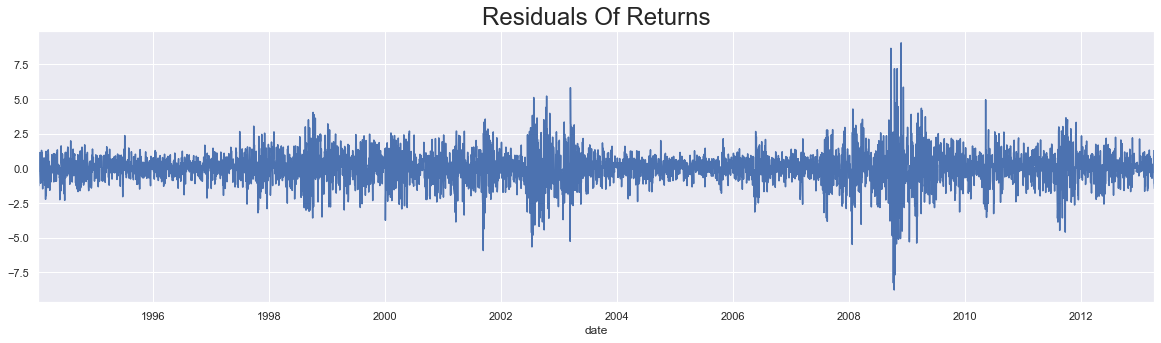

In [24]:
df.res_ret_ma_8[1:].plot(figsize = (20,5))
plt.title("Residuals Of Returns", size = 24)
plt.show()

##### NOTE - To test that the residuals resemble a white noise process, we can check for stationary. If the data is non stationary, it can't be considered white noise. Thus we run the adjusted DF test.

In [25]:
sts.adfuller(df.res_ret_ma_8[2:])

(-70.84179977487116,
 0.0,
 0,
 5017,
 {'1%': -3.431654095870046,
  '5%': -2.8621162697870046,
  '10%': -2.5670767490325597},
 15681.854119490588)

#### `P = 0.0 -> Dataset is stationary.`

#### Even though we got our desired result from the test, `stationarity is not the same as white noise.` So we should also examine the ACF of the residuals.

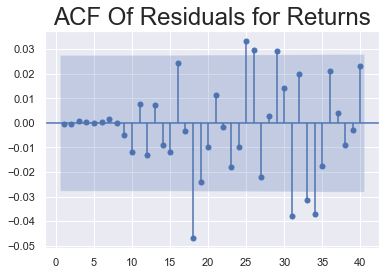

In [26]:
sgt.plot_acf(df.res_ret_ma_8[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns", size = 24)
plt.show()

In [27]:
df['res_ret_ma_6'] = results_ret_ma_6.resid[1:]

In [28]:
print("The mean of the residuals is " + str(round(df.res_ret_ma_6.mean(),3)) + "\nThe variance of the residuals is " + str(round(df.res_ret_ma_6.var(),3)))

The mean of the residuals is 0.0
The variance of the residuals is 1.358


In [29]:
round(sqrt(df.res_ret_ma_6.var()),3)

1.165

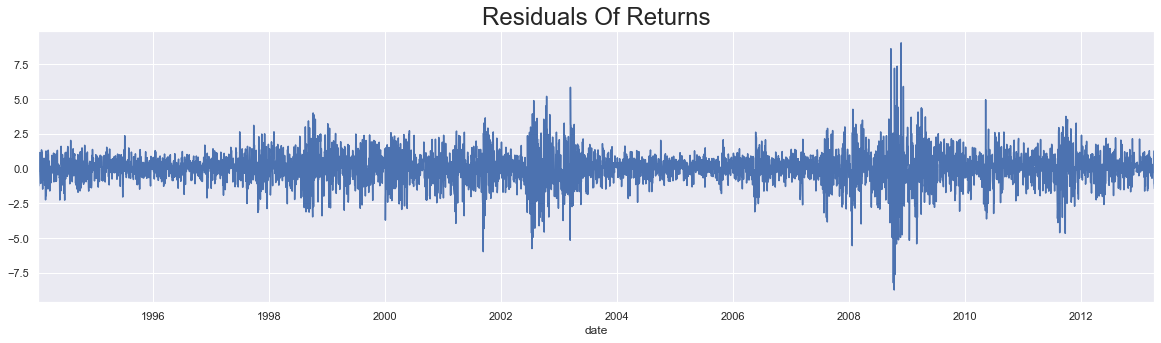

In [30]:
df.res_ret_ma_6[1:].plot(figsize = (20,5))
plt.title("Residuals Of Returns", size = 24)
plt.show()

In [31]:
sts.adfuller(df.res_ret_ma_6[2:])

(-70.8459390312848,
 0.0,
 0,
 5017,
 {'1%': -3.431654095870046,
  '5%': -2.8621162697870046,
  '10%': -2.5670767490325597},
 15688.923568754008)

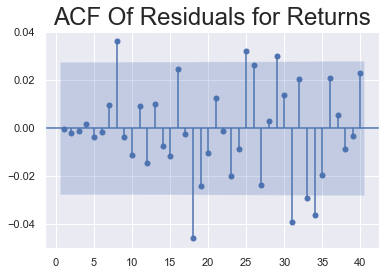

In [32]:
sgt.plot_acf(df.res_ret_ma_6[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns", size = 24)
plt.show()

### Normalized Returns

In [33]:
bench_ret = df.returns.iloc[1]
df['norm_ret'] = df.returns.div(bench_ret).mul(100)

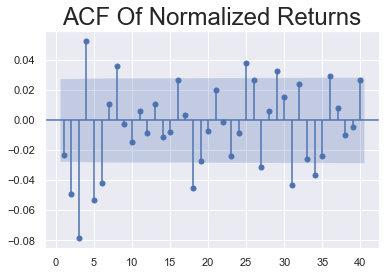

In [34]:
sgt.plot_acf(df.norm_ret[1:], zero = False, lags = 40)
plt.title("ACF Of Normalized Returns", size = 24)
plt.show()

In [35]:
model_norm_ret_ma_8 = ARMA(df.norm_ret[1:], order = (0,8))
results_norm_ret_ma_8 = model_norm_ret_ma_8.fit()
results_norm_ret_ma_8.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.42555D+00    |proj g|=  2.68230D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      4      6      1     0     0   2.665D-07   6.426D+00
  F =   6.4255507143272483     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5019
Model:                     ARMA(0, 8)   Log Likelihood              -32249.839
Method:                       css-mle   S.D. of innovations            149.397
Date:                Fri, 21 Jan 2022   AIC                          64519.678
Time:                        01:17:09   BIC                          64584.888
Sample:                    01-11-1994   HQIC                         64542.529
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.4310      1.779     -1.366      0.172      -5.918       1.057
ma.L1.norm_ret    -0.0238      0.014     -1.690      0.091      -0.051       0.004
ma.L2.norm_ret    -0.0496      0.014     -3.517      0.000      -0.077      -0.022
ma.L3.norm_ret    -0.0847      0.014     -5.993      0.000      -0.112      -0.057
ma.L4.norm_ret     0.0489      0.014      3.443      0.001       0.021       0.077
ma.L5.norm_ret    -0.0518      0.014     -3.633      0.000      -0.080      -0.024
ma.L6.norm_ret    -0.0401      0.014     -2.784      0.005      -0.068      -0.012
ma.L7.norm_ret     0.0084      0.014      0.590      0.555      -0.020       0.036
ma.L8.norm_ret     0.0365      0.014      2.625      0.009       0.009       0.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.4714           -0.4284j            1.5325           -0.0451
MA.2            1.4714           +0.4284j            1.5325            0.0451
MA.3            0.5944           -1.3170j            1.4449           -0.1825
MA.4            0.5944           +1.3170j            1.4449            0.1825
MA.5           -0.7320           -1.2736j            1.4690           -0.3330
MA.6           -0.7320           +1.2736j            1.4690            0.3330
MA.7           -1.4487           -0.6984j            1.6083           -0.4285
MA.8           -1.4487           +0.6984j            1.6083            0.4285
-----------------------------------------------------------------------------
"""

##### NOTE - Normalizing the input data has no effect on model selection.

In [36]:
df['res_norm_ret_ma_8'] = results_ret_ma_8.resid[1:]

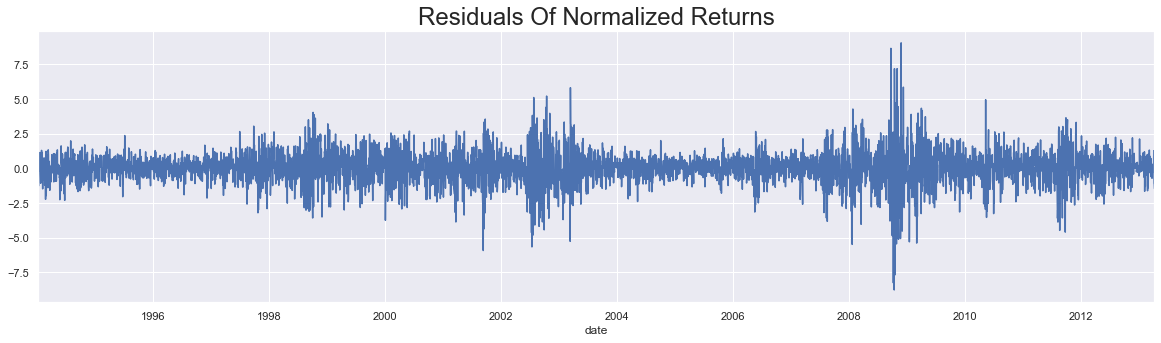

In [37]:
df.res_norm_ret_ma_8[1:].plot(figsize = (20,5))
plt.title("Residuals Of Normalized Returns", size = 24)
plt.show()

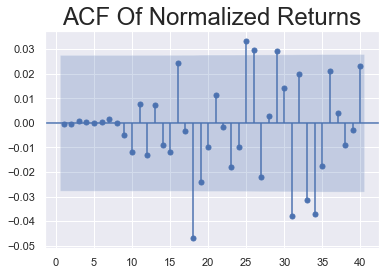

In [38]:
sgt.plot_acf(df.res_norm_ret_ma_8[2:], zero = False, lags = 40)
plt.title("ACF Of Normalized Returns", size = 24)
plt.show()

##### NOTE - White noise means the errors don't follow a pattern.

### MA Models for Prices

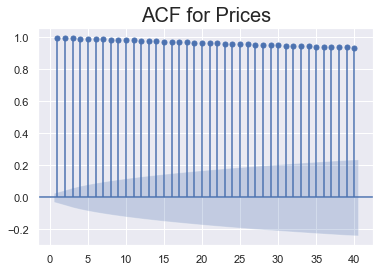

In [39]:
sgt.plot_acf(df.market_value, zero = False, lags = 40)
plt.title("ACF for Prices", size = 20)
plt.show()

##### NOTE - The above graph suggests that `MA(P+1) > MA(P)`. This suggests that a MA(infinte) model will be an ideal fit but since no such thing exists therefore, any MA model won't be a good fit.

In [41]:
model_ma_1 = ARMA(df.market_value, order = (0,1))
results_ma_1 = model_ma_1.fit()
results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                     ARMA(0, 1)   Log Likelihood              -38620.604
Method:                       css-mle   S.D. of innovations            530.681
Date:                Fri, 21 Jan 2022   AIC                          77247.207
Time:                        01:17:22   BIC                          77266.771
Sample:                    01-10-1994   HQIC                         77254.063
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.9228     14.659    347.227      0.000    5061.192    5118.653
ma.L1.market_value     0.9573      0.003    335.389      0.000       0.952       0.963
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0446           +0.0000j            1.0446            0.5000
-----------------------------------------------------------------------------
"""

<img src = "Images/ma1.png">
<img src = "Images/maeq.png">

Hence, MA(1) model where `all the coefficients are extremely close to one` is just an approximation of an AR model, which only takes the `error term from N periods back.`

##### NOTE - MA models do not perform well for non-stationary data.

#### "MA Models are great in modelling Random Walks because they take into account our mistakes."

The MA aspect of models does that, however, to actually do a decent job at modeling a non stationary process, a model should also use the previous periods values as a sort of diving board and that means `some combinations of AR and MA models would be best.`

## Conclusion

### AR Model
1. Made good predictions.
2. Failed to adjust quickly to unexpected shocks.

### MA Model
1. Smooth out the predictions. 
2. Accounted only for the residuals. 
3. Needed a baseline to perform well so we could use previous values to provide that.

### Introduction to ARMA Model
<img src = "Images/ARMA.png">

<img src = "Images/arma-model.png">

### ARMA Model Equation
<img src = "Images/arma-eq.png">

#### In General:
<img src = "Images/armaa.png">

### Important
<img src = "Images/arma-pq.png">

##### NOTE - It's crucial to understand that the `two orders can be but must not necessarily be equal in value`. This is vital because usually `either the error term or the past value loses significance faster.` Hence, many realistic predictive models have different autoregressive and moving average orders.

### ARMA(1,1)

#### Syntax -> `ARMA(time_series_name, order = (P, Q))`

#### `Degrees of Freedom -> P + Q`

In [73]:
model_ret_ar_1_ma_1 = ARMA(df.returns[1:], order = (1,1))
results_ret_ar_1_ma_1 = model_ret_ar_1_ma_1.fit()
results_ret_ar_1_ma_1.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57710D+00    |proj g|=  4.53881D-04

At iterate    5    f=  1.57710D+00    |proj g|=  7.63345D-04

At iterate   10    f=  1.57709D+00    |proj g|=  3.16169D-04

At iterate   15    f=  1.57709D+00    |proj g|=  1.11022D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   1.110D-07   1.577D+00
  F =   1.5770882206395498     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                     ARMA(1, 1)   Log Likelihood               -7915.406
Method:                       css-mle   S.D. of innovations              1.171
Date:                Thu, 20 Jan 2022   AIC                          15838.812
Time:                        00:34:39   BIC                          15864.896
Sample:                    01-11-1994   HQIC                         15847.952
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.448      0.148      -0.007       0.045
ar.L1.returns     0.7647      0.067     11.338      0.000       0.633       0.897
ma.L1.returns    -0.8139      0.061    -13.393      0.000      -0.933      -0.695
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3077           +0.0000j            1.3077            0.0000
MA.1            1.2286           +0.0000j            1.2286            0.0000
-----------------------------------------------------------------------------
"""

#### `AR coefficient (ar.L1.returns) -> 0.7647 => positive`

#### `MA coefficeint (ma.L1.returns) -> -0.8139 => negative`

<img src = "Images/arma11.png">

In [74]:
model_ret_ar_1 = ARMA(df.returns[1:], order = (1,0))
model_ret_ma_1 = ARMA(df.returns[1:], order = (0,1))

In [75]:
print("\nARMA vs AR", LLR_test(model_ret_ar_1, model_ret_ar_1_ma_1))
print("\nARMA vs MA", LLR_test(model_ret_ma_1, model_ret_ar_1_ma_1))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57973D+00    |proj g|=  1.15241D-04

At iterate    5    f=  1.57973D+00    |proj g|=  2.22045D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   2.220D-08   1.580D+00
  F =   1.5797281163140755     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 v

 This problem is unconstrained.



At iterate   15    f=  1.57709D+00    |proj g|=  1.11022D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   1.110D-07   1.577D+00
  F =   1.5770882206395498     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

ARMA vs AR 0.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57970D+00    |proj g|=  1.26565D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total num

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57710D+00    |proj g|=  4.53881D-04

At iterate    5    f=  1.57710D+00    |proj g|=  7.63345D-04

At iterate   10    f=  1.57709D+00    |proj g|=  3.16169D-04

At iterate   15    f=  1.57709D+00    |proj g|=  1.11022D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   1.110D-07   1.577D+00
  F =   1.5770882206395498     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

ARMA vs

#### `ARMA vs AR 0.0` & `ARMA vs MA 0.0` -> This suggests that using past errors in conjuction with past values results in much better estimators.

Another way of interpreting said results is that our `past estimate has performed better as predictors than actual past values.` This is a bold statement to make, however, if it's true, that means that ARMA models ought to perform well in forecasting values into the future.

<img src = Images/over-par.png>

#### We start with an `over-parametrized ARMA(P,Q)` model and then start decreasing the lags until:

1. All coefficients are significant.
2. High Log-Likelihood 
3. Low Information Criteria

<img src = Images/AR&MA&.png>

##### NOTE -  As per the above graphs, we expect the preferred ARMA model to have no more than 6 AR and at most 8 MA parts.  That happens because if the 6 AR and 8 MA arguments were able to explain the changes period to period on their own, then using them simultaneously would be redundant.

<img src = Images/arma86.png>

##### NOTE - 
`10 of the 14 coefficients`, excluding the constant, are `not significant`. This proves that the model is `unnecessarily complicated`, since `less than half of the coefficients are significantly different from zero.` Hence, if we assume `ARMA(4,3) is half the ARMA(8,6)`, then starting with a `simpler ARMA(3,3)` sounds all the more sensible.

In [79]:
model_ret_ar_3_ma_3 = ARMA(df.returns[1:], order = (3,3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()
results_ret_ar_3_ma_3.summary()
LLR_test(model_ret_ar_1_ma_1, model_ret_ar_3_ma_3, DF = 4)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57252D+00    |proj g|=  3.72280D-04

At iterate    5    f=  1.57252D+00    |proj g|=  3.90354D-04

At iterate   10    f=  1.57251D+00    |proj g|=  4.45932D-04

At iterate   15    f=  1.57251D+00    |proj g|=  2.20224D-04

At iterate   20    f=  1.57251D+00    |proj g|=  2.12053D-05

At iterate   25    f=  1.57251D+00    |proj g|=  1.47726D-04

At iterate   30    f=  1.57251D+00    |proj g|=  2.68674D-06

At iterate   35    f=  1.57251D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57710D+00    |proj g|=  4.53881D-04

At iterate    5    f=  1.57710D+00    |proj g|=  7.63345D-04

At iterate   10    f=  1.57709D+00    |proj g|=  3.16169D-04

At iterate   15    f=  1.57709D+00    |proj g|=  1.11022D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   1.110D-07   1.577D+00
  F =   1.5770882206395498     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57252D+00    |proj g|=  3.72280D-04

At iterate    5    f=  1.57252D+00    |proj g|=  3.90354D-04

At iterate   10    f=  1.57251D+00    |proj g|=  4.45932D-04

At iterate   15    f=  1.57251D+00    |proj g|=  2.20224D-04

At iterate   20    f=  1.57251D+00    |proj g|=  2.12053D-05

At iterate   25    f=  1.57251D+00    |proj g|=  1.47726D-04

At iterate   30    f=  1.57251D+00    |proj g|=  2.68674D-06

At iterate   35    f=  1.57251D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

0.0

ARMA (3,3) -> 6 coefficients

ARMA (1,1) -> 2 coefficents

#### => `DF = 6 - 2 = 4`

#### Best Fit will be between `ARMA(1,1)` and `ARMA(3,3)`.

In [80]:
model_ret_ar_3_ma_2 = ARMA(df.returns[1:], order = (3,2))
results_ret_ar_3_ma_2 = model_ret_ar_3_ma_2.fit()
results_ret_ar_3_ma_2.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57295D+00    |proj g|=  2.85860D-04

At iterate    5    f=  1.57295D+00    |proj g|=  1.81299D-04

At iterate   10    f=  1.57295D+00    |proj g|=  1.71863D-05

At iterate   15    f=  1.57295D+00    |proj g|=  1.72062D-04


 This problem is unconstrained.



At iterate   20    f=  1.57295D+00    |proj g|=  2.22045D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     23      1     0     0   2.220D-08   1.573D+00
  F =   1.5729482125147189     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                     ARMA(3, 2)   Log Likelihood               -7894.627
Method:                       css-mle   S.D. of innovations              1.166
Date:                Thu, 20 Jan 2022   AIC                          15803.254
Time:                        15:17:49   BIC                          15848.901
Sample:                    01-11-1994   HQIC                         15819.250
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.255      0.209      -0.011       0.048
ar.L1.returns    -0.6786      0.087     -7.800      0.000      -0.849      -0.508
ar.L2.returns    -0.5084      0.139     -3.669      0.000      -0.780      -0.237
ar.L3.returns    -0.1142      0.015     -7.661      0.000      -0.143      -0.085
ma.L1.returns     0.6569      0.087      7.538      0.000       0.486       0.828
ma.L2.returns     0.4469      0.141      3.174      0.002       0.171       0.723
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4929           -1.5110j            1.5893           -0.3002
AR.2           -0.4929           +1.5110j            1.5893            0.3002
AR.3           -3.4681           -0.0000j            3.4681           -0.5000
MA.1           -0.7349           -1.3028j            1.4958           -0.3317
MA.2           -0.7349           +1.3028j            1.4958            0.3317
-----------------------------------------------------------------------------
"""

##### NOTE - As the lags increase the absolute values for the AR as well as the MA coefficients decrease, this supports the idea that the further back in time we go, the less relevant values and errors become.

<img src = Images/a.png>

<img src = Images/b.png>

<img src = Images/c.png>

In [81]:
model_ret_ar_2_ma_3 = ARMA(df.returns[1:], order = (2,3))
results_ret_ar_2_ma_3 = model_ret_ar_2_ma_3.fit()
results_ret_ar_2_ma_3.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57292D+00    |proj g|=  2.36700D-04

At iterate    5    f=  1.57292D+00    |proj g|=  8.78608D-04

At iterate   10    f=  1.57292D+00    |proj g|=  9.45910D-06

At iterate   15    f=  1.57292D+00    |proj g|=  7.71827D-05

At iterate   20    f=  1.57292D+00    |proj g|=  6.88338D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     29      1     0     0   6.661D-08   1.573D+00
  F =   1.5729163634487697     

CONVERG

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                     ARMA(2, 3)   Log Likelihood               -7894.467
Method:                       css-mle   S.D. of innovations              1.166
Date:                Thu, 20 Jan 2022   AIC                          15802.934
Time:                        15:24:15   BIC                          15848.581
Sample:                    01-11-1994   HQIC                         15818.930
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.280      0.200      -0.010       0.048
ar.L1.returns    -0.5605      0.090     -6.247      0.000      -0.736      -0.385
ar.L2.returns    -0.4179      0.193     -2.163      0.031      -0.797      -0.039
ma.L1.returns     0.5378      0.090      6.002      0.000       0.362       0.713
ma.L2.returns     0.3531      0.195      1.810      0.070      -0.029       0.736
ma.L3.returns    -0.1159      0.016     -7.374      0.000      -0.147      -0.085
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6706           -1.3939j            1.5469           -0.3214
AR.2           -0.6706           +1.3939j            1.5469            0.3214
MA.1           -0.7280           -1.1772j            1.3842           -0.3381
MA.2           -0.7280           +1.1772j            1.3842            0.3381
MA.3            4.5016           -0.0000j            4.5016           -0.0000
-----------------------------------------------------------------------------
"""

In [82]:
LLR_test(model_ret_ar_2_ma_3, model_ret_ar_3_ma_3)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57292D+00    |proj g|=  2.36700D-04

At iterate    5    f=  1.57292D+00    |proj g|=  8.78608D-04

At iterate   10    f=  1.57292D+00    |proj g|=  9.45910D-06


 This problem is unconstrained.



At iterate   15    f=  1.57292D+00    |proj g|=  7.71827D-05

At iterate   20    f=  1.57292D+00    |proj g|=  6.88338D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     29      1     0     0   6.661D-08   1.573D+00
  F =   1.5729163634487697     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57252D+00    |proj g|=  3.72280D-04

At iterate    5    f=  1.57252D+00    |proj g|=  3.90354D-04


 This problem is unconstrained.



At iterate   10    f=  1.57251D+00    |proj g|=  4.45932D-04

At iterate   15    f=  1.57251D+00    |proj g|=  2.20224D-04

At iterate   20    f=  1.57251D+00    |proj g|=  2.12053D-05

At iterate   25    f=  1.57251D+00    |proj g|=  1.47726D-04

At iterate   30    f=  1.57251D+00    |proj g|=  2.68674D-06

At iterate   35    f=  1.57251D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     41      1     0     0   1.776D-07   1.573D+00
  F =   1.5725072857907942     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


0.043

#### P value = 0.043 -> Difference is significant at the 5% level but just barely. This indicates that we should opt for the ARMA(3,3) model instead of the ARMA(2,3) model if we had to choose `only` between these two.

In [83]:
model_ret_ar_3_ma_1 = ARMA(df.returns[1:], order = (3,1))
results_ret_ar_3_ma_1 = model_ret_ar_3_ma_1.fit()
results_ret_ar_3_ma_1.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57361D+00    |proj g|=  4.03277D-04

At iterate    5    f=  1.57361D+00    |proj g|=  9.01501D-06

At iterate   10    f=  1.57361D+00    |proj g|=  3.10862D-05

At iterate   15    f=  1.57361D+00    |proj g|=  2.22045D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     18      1     0     0   2.220D-08   1.574D+00
  F =   1.5736115697247195     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                     ARMA(3, 1)   Log Likelihood               -7897.956
Method:                       css-mle   S.D. of innovations              1.167
Date:                Thu, 20 Jan 2022   AIC                          15807.913
Time:                        15:31:24   BIC                          15847.039
Sample:                    01-11-1994   HQIC                         15821.623
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.302      0.193      -0.010       0.047
ar.L1.returns    -0.5078      0.088     -5.773      0.000      -0.680      -0.335
ar.L2.returns    -0.0639      0.016     -4.027      0.000      -0.095      -0.033
ar.L3.returns    -0.1102      0.014     -7.853      0.000      -0.138      -0.083
ma.L1.returns     0.4839      0.088      5.504      0.000       0.312       0.656
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5093           -0.0000j            1.5093           -0.5000
AR.2            0.4650           -2.4070j            2.4515           -0.2196
AR.3            0.4650           +2.4070j            2.4515            0.2196
MA.1           -2.0665           +0.0000j            2.0665            0.5000
-----------------------------------------------------------------------------
"""

All P values for AR and MA components are significant except for the coefficient.

`AR coefficients -> negative` & `MA coefficients -> positive` => Makes sense from a financial point of view.


In [84]:
LLR_test(model_ret_ar_3_ma_1, model_ret_ar_3_ma_2)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57361D+00    |proj g|=  4.03277D-04

At iterate    5    f=  1.57361D+00    |proj g|=  9.01501D-06

At iterate   10    f=  1.57361D+00    |proj g|=  3.10862D-05

At iterate   15    f=  1.57361D+00    |proj g|=  2.22045D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     18      1     0     0   2.220D-08   1.574D+00
  F =   1.5736115697247195     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57295D+00    |proj g|=  2.85860D-04

At iterate    5    f=  1.57295D+00    |proj g|=  1.81299D-04

At iterate   10    f=  1.57295D+00    |proj g|=  1.71863D-05

At iterate   15    f=  1.57295D+00    |proj g|=  1.72062D-04

At iterate   20    f=  1.57295D+00    |proj g|=  2.22045D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     23      1     0     0   2.220D-08   1.573D+00
  F =   1.5729482125147189     

CONVERG

0.01

#### Since the LLR test gives P value = 0.01 => `ARMA(3,2) > ARMA(3,1)`

In [85]:
model_ret_ar_2_ma_2 = ARMA(df.returns[1:], order = (2,2))
results_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
results_ret_ar_2_ma_2.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57646D+00    |proj g|=  4.61564D-04

At iterate    5    f=  1.57646D+00    |proj g|=  1.68476D-03

At iterate   10    f=  1.57644D+00    |proj g|=  1.59939D-04

At iterate   15    f=  1.57644D+00    |proj g|=  2.23666D-04


 This problem is unconstrained.



At iterate   20    f=  1.57643D+00    |proj g|=  6.34381D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     30      1     0     0   6.661D-08   1.576D+00
  F =   1.5764347905423370     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                     ARMA(2, 2)   Log Likelihood               -7912.126
Method:                       css-mle   S.D. of innovations              1.171
Date:                Thu, 20 Jan 2022   AIC                          15836.252
Time:                        15:35:41   BIC                          15875.378
Sample:                    01-11-1994   HQIC                         15849.963
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.396      0.163      -0.008       0.046
ar.L1.returns     0.7815      0.238      3.285      0.001       0.315       1.248
ar.L2.returns    -0.1562      0.176     -0.885      0.376      -0.502       0.190
ma.L1.returns    -0.8099      0.239     -3.390      0.001      -1.278      -0.342
ma.L2.returns     0.1176      0.187      0.628      0.530      -0.249       0.484
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5012           -0.3813j            2.5301           -0.0241
AR.2            2.5012           +0.3813j            2.5301            0.0241
MA.1            1.6119           +0.0000j            1.6119            0.0000
MA.2            5.2748           +0.0000j            5.2748            0.0000
-----------------------------------------------------------------------------
"""

#### `ar.L2.returns` & `ma.L2.returns` are not significant. Since P > 0.05.

#### Both non-significant coefficients are associated with the second lag, which also happens to be the last one. This leads us to believe that simpler models like the ARMA(1,2) or the ARMA(2,1) would outperform it. And that signals us to avoid the ARMA(2,2) at all costs.

In [86]:
model_ret_ar_1_ma_3 = ARMA(df.returns[1:], order = (1,3))
results_ret_ar_1_ma_3 = model_ret_ar_1_ma_3.fit()
results_ret_ar_1_ma_3.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57317D+00    |proj g|=  7.19425D-05

At iterate    5    f=  1.57317D+00    |proj g|=  5.21805D-05

At iterate   10    f=  1.57317D+00    |proj g|=  1.48770D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     17      1     0     0   4.441D-08   1.573D+00
  F =   1.5731664537908594     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                     ARMA(1, 3)   Log Likelihood               -7895.722
Method:                       css-mle   S.D. of innovations              1.167
Date:                Thu, 20 Jan 2022   AIC                          15803.445
Time:                        15:39:40   BIC                          15842.571
Sample:                    01-11-1994   HQIC                         15817.155
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.336      0.181      -0.009       0.047
ar.L1.returns    -0.4700      0.096     -4.906      0.000      -0.658      -0.282
ma.L1.returns     0.4475      0.095      4.696      0.000       0.261       0.634
ma.L2.returns    -0.0638      0.015     -4.117      0.000      -0.094      -0.033
ma.L3.returns    -0.1183      0.014     -8.203      0.000      -0.147      -0.090
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1276           +0.0000j            2.1276            0.5000
MA.1           -1.4881           -1.1203j            1.8626           -0.3973
MA.2           -1.4881           +1.1203j            1.8626            0.3973
MA.3            2.4371           -0.0000j            2.4371           -0.0000
-----------------------------------------------------------------------------
"""

<img src = Images/d.png>

<img src = Images/e.png>

##### NOTE - When we don't have nested ARMA models, we have manually compare the `Log Likelihood`, `AIC`, and `BIC`.

#### The ideal model should have the following:
1. Higher LLR.
2. Lower AIC.

In [88]:
print("\n ARMA(3,2): \tLL = ", results_ret_ar_3_ma_2.llf, "\tAIC = ", results_ret_ar_3_ma_2.aic)
print("\n ARMA(1,3): \tLL = ",results_ret_ar_1_ma_3.llf, "\tAIC = ", results_ret_ar_1_ma_3.aic)


 ARMA(3,2): 	LL =  -7894.627078611375 	AIC =  15803.25415722275

 ARMA(1,3): 	LL =  -7895.722431576323 	AIC =  15803.444863152647


##### NOTE - From the above results, we see that  `ARMA(3,2) > ARMA(1,3)`

#### Therefore, ARMA(3,2) is the best model here for the following reasons:
1. We get all significant coefficients.
2. The model outpredicts all less-complex alternatives.

### Residuals for Returns

In [89]:
df['res_ret_ar_3_ma_2'] = results_ret_ar_3_ma_2.resid[1:]

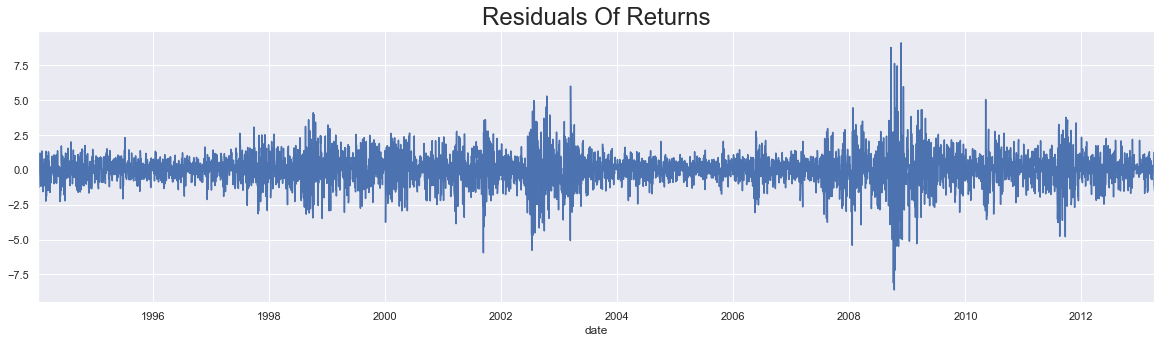

In [90]:
df.res_ret_ar_3_ma_2.plot(figsize = (20,5))
plt.title("Residuals Of Returns", size = 24)
plt.show()

##### NOTE - The above graph is similar to the Residuals plots of the AR and MA models. This is because the volatility in returns might not be fully comprehendable if we use only ARMA models.

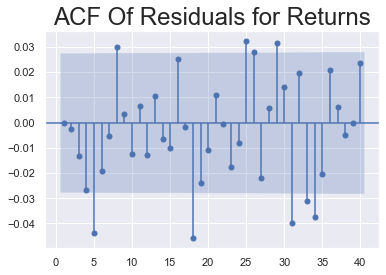

In [91]:
sgt.plot_acf(df.res_ret_ar_3_ma_2[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns", size = 24)
plt.show()

<img src = Images/f.png>

<img src = Images/g.png>

### Reevaluating Model Selection

In [92]:
model_ret_ar_5_ma_5 = ARMA(df.returns[1:], order = (5,5))
results_ret_ar_5_ma_5 = model_ret_ar_5_ma_5.fit()
results_ret_ar_5_ma_5.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57035D+00    |proj g|=  1.53413D-03

At iterate    5    f=  1.57033D+00    |proj g|=  1.83549D-03

At iterate   10    f=  1.57032D+00    |proj g|=  9.27880D-04

At iterate   15    f=  1.57028D+00    |proj g|=  2.10898D-03

At iterate   20    f=  1.57027D+00    |proj g|=  1.23257D-04

At iterate   25    f=  1.57026D+00    |proj g|=  1.79690D-03

At iterate   30    f=  1.57025D+00    |proj g|=  1.92935D-04

At iterate   35    f=  1.57025D+00    |proj g|=  1.54987D-04

At iterate   40    f=  1.57025D+00    |proj g|=  8.86158D-04

At iterate   45    f=  1.57025D+00    |proj g|=  2.08211D-04

At iterate   50    f=  1.57025D+00    |proj g|=  5.30687D-05

At iterate   55    f=  1.57025D+00    |proj g|=  2.10743D-04

At iterate   60    f=  1.57025D+00    |proj g|=  9.01501D-05

At iterate   65    f=  1.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                     ARMA(5, 5)   Log Likelihood               -7881.065
Method:                       css-mle   S.D. of innovations              1.163
Date:                Thu, 20 Jan 2022   AIC                          15786.131
Time:                        16:07:30   BIC                          15864.382
Sample:                    01-11-1994   HQIC                         15813.551
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.405      0.160      -0.007       0.045
ar.L1.returns    -0.0687      0.140     -0.492      0.623      -0.343       0.205
ar.L2.returns    -0.6723      0.146     -4.604      0.000      -0.958      -0.386
ar.L3.returns    -0.1155      0.141     -0.819      0.413      -0.392       0.161
ar.L4.returns     0.1775      0.129      1.378      0.168      -0.075       0.430
ar.L5.returns     0.1214      0.107      1.131      0.258      -0.089       0.332
ma.L1.returns     0.0446      0.138      0.324      0.746      -0.225       0.315
ma.L2.returns     0.6224      0.144      4.322      0.000       0.340       0.905
ma.L3.returns     0.0109      0.136      0.080      0.936      -0.256       0.278
ma.L4.returns    -0.1749      0.122     -1.433      0.152      -0.414       0.064
ma.L5.returns    -0.2239      0.104     -2.148      0.032      -0.428      -0.020
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0871           -1.0365j            1.0402           -0.2367
AR.2            0.0871           +1.0365j            1.0402            0.2367
AR.3            1.7727           -0.0000j            1.7727           -0.0000
AR.4           -1.7046           -1.1787j            2.0724           -0.4037
AR.5           -1.7046           +1.1787j            2.0724            0.4037
MA.1            0.1034           -1.0436j            1.0487           -0.2343
MA.2            0.1034           +1.0436j            1.0487            0.2343
MA.3            1.4862           -0.0000j            1.4862           -0.0000
MA.4           -1.2370           -1.0965j            1.6530           -0.3846
MA.5           -1.2370           +1.0965j            1.6530            0.3846
-----------------------------------------------------------------------------
"""

##### NOTE - We can see that all the three of its coefficients were significant, hence taking both returns and residuals five periods ago is redundant and we should only focus on one of the two.

The shortlisted models after testing all models are - `ARMA(1,5) and ARMA(5,1)`

We can't apply the LLR test to ARMA(1,5) and ARMA(5,1) as they have the `same degrees of freedom`

Therefore, we should compare their `Log Likelihood` and `AIC` values.

In [93]:
model_ret_ar_5_ma_1 = ARMA(df.returns[1:], order = (5,1))
results_ret_ar_5_ma_1 = model_ret_ar_5_ma_1.fit()
results_ret_ar_5_ma_1.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57167D+00    |proj g|=  1.52611D-04

At iterate    5    f=  1.57167D+00    |proj g|=  1.19238D-05

At iterate   10    f=  1.57167D+00    |proj g|=  5.46896D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     14     16      1     0     0   1.110D-07   1.572D+00
  F =   1.5716688538404584     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                     ARMA(5, 1)   Log Likelihood               -7888.206
Method:                       css-mle   S.D. of innovations              1.165
Date:                Thu, 20 Jan 2022   AIC                          15792.412
Time:                        16:12:10   BIC                          15844.580
Sample:                    01-11-1994   HQIC                         15810.692
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.013      1.411      0.158      -0.007       0.045
ar.L1.returns     0.3437      0.131      2.619      0.009       0.087       0.601
ar.L2.returns    -0.0459      0.015     -3.008      0.003      -0.076      -0.016
ar.L3.returns    -0.0652      0.016     -4.010      0.000      -0.097      -0.033
ar.L4.returns     0.0741      0.018      4.069      0.000       0.038       0.110
ar.L5.returns    -0.0813      0.014     -5.686      0.000      -0.109      -0.053
ma.L1.returns    -0.3670      0.131     -2.796      0.005      -0.624      -0.110
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6157           -0.0000j            1.6157           -0.5000
AR.2            1.3795           -0.8617j            1.6265           -0.0889
AR.3            1.3795           +0.8617j            1.6265            0.0889
AR.4           -0.1156           -1.6927j            1.6967           -0.2608
AR.5           -0.1156           +1.6927j            1.6967            0.2608
MA.1            2.7249           +0.0000j            2.7249            0.0000
-----------------------------------------------------------------------------
"""

In [94]:
model_ret_ar_1_ma_5 = ARMA(df.returns[1:], order = (1,5))
results_ret_ar_1_ma_5 = model_ret_ar_1_ma_5.fit()
results_ret_ar_1_ma_5.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57200D+00    |proj g|=  2.37610D-04

At iterate    5    f=  1.57200D+00    |proj g|=  1.58762D-05

At iterate   10    f=  1.57200D+00    |proj g|=  1.71418D-04

At iterate   15    f=  1.57200D+00    |proj g|=  9.10383D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     22      1     0     0   6.661D-08   1.572D+00
  F =   1.5719997484231236     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                     ARMA(1, 5)   Log Likelihood               -7889.867
Method:                       css-mle   S.D. of innovations              1.165
Date:                Thu, 20 Jan 2022   AIC                          15795.733
Time:                        16:12:46   BIC                          15847.901
Sample:                    01-11-1994   HQIC                         15814.014
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.013      1.422      0.155      -0.007       0.045
ar.L1.returns     0.3281      0.152      2.155      0.031       0.030       0.627
ma.L1.returns    -0.3531      0.152     -2.329      0.020      -0.650      -0.056
ma.L2.returns    -0.0405      0.015     -2.627      0.009      -0.071      -0.010
ma.L3.returns    -0.0679      0.017     -4.022      0.000      -0.101      -0.035
ma.L4.returns     0.0743      0.020      3.772      0.000       0.036       0.113
ma.L5.returns    -0.0683      0.015     -4.657      0.000      -0.097      -0.040
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.0475           +0.0000j            3.0475            0.0000
MA.1           -1.1896           -1.1547j            1.6578           -0.3774
MA.2           -1.1896           +1.1547j            1.6578            0.3774
MA.3            1.5045           -0.0000j            1.5045           -0.0000
MA.4            0.9810           -1.6058j            1.8817           -0.1627
MA.5            0.9810           +1.6058j            1.8817            0.1627
-----------------------------------------------------------------------------
"""

In [95]:
print("\n ARMA(5,1): \tLL = ", results_ret_ar_5_ma_1.llf, "\tAIC = ", results_ret_ar_5_ma_1.aic)
print("\n ARMA(1,5): \tLL = ",results_ret_ar_1_ma_5.llf, "\tAIC = ", results_ret_ar_1_ma_5.aic)


 ARMA(5,1): 	LL =  -7888.205977425261 	AIC =  15792.411954850522

 ARMA(1,5): 	LL =  -7889.8667373356575 	AIC =  15795.733474671315


##### NOTE - From the above results, we can conclude that `ARMA(5,1) > ARMA(1,5)`

<img src = Images/i.png>

In [96]:
print("\n ARMA(5,1): \tLL = ", results_ret_ar_5_ma_1.llf, "\tAIC = ", results_ret_ar_5_ma_1.aic)
print("\n ARMA(3,2): \tLL = ",results_ret_ar_3_ma_2.llf, "\tAIC = ", results_ret_ar_3_ma_2.aic)


 ARMA(5,1): 	LL =  -7888.205977425261 	AIC =  15792.411954850522

 ARMA(3,2): 	LL =  -7894.627078611375 	AIC =  15803.25415722275


##### NOTE - From the above results, we can conclude that `ARMA(5,1) > ARMA(3,2)`


### Important
A.R. and models have ACF and PACF to provide the suggested optimal number of lags needed. Unfortunately, ARMA models lack such functions. Therefore, we can make the mistake of starting off with a model whose order is lower than the optimal one. This is why `examining the residuals is crucial in finding the best approximate.`


### Residuals for the New Model

In [97]:
df['res_ret_ar_5_ma_1'] = results_ret_ar_5_ma_1.resid

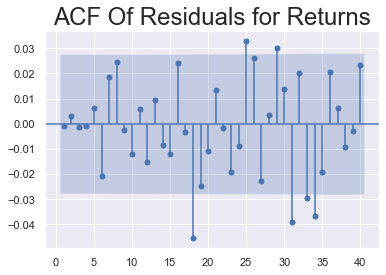

In [99]:
sgt.plot_acf(df.res_ret_ar_5_ma_1[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns", size = 24)
plt.show()

### ARMA Models for Prices

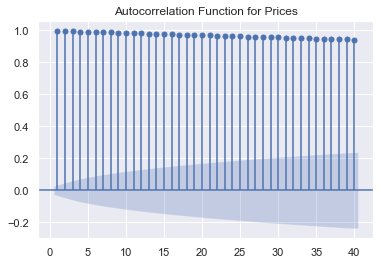

In [100]:
sgt.plot_acf(df.market_value, unbiased = True, zero = False, lags = 40)
plt.title("Autocorrelation Function for Prices")
plt.show()

##### NOTE - The ACF graph above suggests that we use a MA(infinite) model which does not exist but it is equivalent to a simple AR model. Therefore, as long as we include AR components, we should be able to describe the data well.

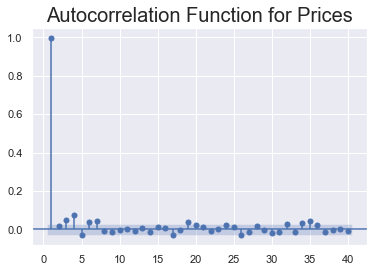

In [101]:
sgt.plot_pacf(df.market_value, alpha = 0.05, zero = False, lags = 40, method = ('ols'))
plt.title("Autocorrelation Function for Prices", size = 20)
plt.show()

In [102]:
model_ar_1_ma_1 = ARMA(df.market_value, order = (1,1))
results_ar_1_ma_1 = model_ar_1_ma_1.fit()
results_ar_1_ma_1.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.50137D+00    |proj g|=  1.93801D-04

At iterate    5    f=  5.50135D+00    |proj g|=  1.24345D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   2.665D-07   5.501D+00
  F =   5.5013519904828758     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood              -27616.787
Method:                       css-mle   S.D. of innovations             59.254
Date:                Thu, 20 Jan 2022   AIC                          55241.574
Time:                        16:42:59   BIC                          55267.659
Sample:                    01-10-1994   HQIC                         55250.714
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.9686    497.166     10.238      0.000    4115.541    6064.396
ar.L1.market_value     0.9985      0.001   1322.831      0.000       0.997       1.000
ma.L1.market_value    -0.0190      0.015     -1.274      0.203      -0.048       0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
MA.1           52.5025           +0.0000j           52.5025            0.0000
-----------------------------------------------------------------------------
"""

Since, `ma.L1.market_value is not significant`. This indicates that the simple model is not the best fit.

##### NOTE - To avoid the same mistake, we want to analyse the residuals before examining our over-parametrized model.

In [103]:
df['res_ar_1_ma_1'] = results_ar_1_ma_1.resid

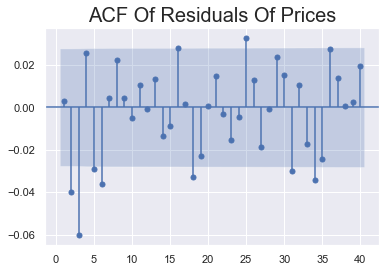

In [104]:
sgt.plot_acf(df.res_ar_1_ma_1, zero = False, lags = 40)
plt.title("ACF Of Residuals Of Prices", size = 20)
plt.show()

In [108]:
model_ar_6_ma_6 = ARMA(df.market_value, order = (6,6))
results_ar_6_ma_6 = model_ar_6_ma_6.fit(start_ar_lags = 11)
results_ar_6_ma_6.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.49465D+00    |proj g|=  8.98126D-04

At iterate    5    f=  5.49463D+00    |proj g|=  6.21103D-04

At iterate   10    f=  5.49462D+00    |proj g|=  5.50493D-04

At iterate   15    f=  5.49462D+00    |proj g|=  1.63158D-04

At iterate   20    f=  5.49462D+00    |proj g|=  2.66276D-04

At iterate   25    f=  5.49461D+00    |proj g|=  1.14486D-04

At iterate   30    f=  5.49461D+00    |proj g|=  9.14824D-05

At iterate   35    f=  5.49461D+00    |proj g|=  2.42917D-04

At iterate   40    f=  5.49461D+00    |proj g|=  4.19220D-05

At iterate   45    f=  5.49461D+00    |proj g|=  2.48246D-04

At iterate   50    f=  5.49461D+00    |proj g|=  2.17248D-04

At iterate   55    f=  5.49461D+00    |proj g|=  1.32339D-05

At iterate   60    f=  5.49461D+00    |proj g|=  1.21680D-05

At iterate   65    f=  5.4

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                     ARMA(6, 6)   Log Likelihood              -27582.934
Method:                       css-mle   S.D. of innovations             58.855
Date:                Thu, 20 Jan 2022   AIC                          55193.867
Time:                        16:49:35   BIC                          55285.164
Sample:                    01-10-1994   HQIC                         55225.859
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.9712    569.262      8.941      0.000    3974.239    6205.704
ar.L1.market_value     1.9279      0.032     60.574      0.000       1.866       1.990
ar.L2.market_value    -1.7363      0.040    -43.802      0.000      -1.814      -1.659
ar.L3.market_value     1.2684      0.034     37.116      0.000       1.201       1.335
ar.L4.market_value    -0.2380      0.161     -1.476      0.140      -0.554       0.078
ar.L5.market_value    -0.4058      0.168     -2.412      0.016      -0.736      -0.076
ar.L6.market_value     0.1836      0.049      3.783      0.000       0.088       0.279
ma.L1.market_value    -0.9490      0.035    -27.292      0.000      -1.017      -0.881
ma.L2.market_value     0.7800      0.032     24.278      0.000       0.717       0.843
ma.L3.market_value    -0.5091      0.031    -16.431      0.000      -0.570      -0.448
ma.L4.market_value    -0.1561      0.162     -0.963      0.335      -0.474       0.161
ma.L5.market_value     0.0948      0.056      1.680      0.093      -0.016       0.205
ma.L6.market_value     0.0671      0.024      2.778      0.005       0.020       0.114
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0857           -1.0502j            1.0537           -0.2370
AR.2            0.0857           +1.0502j            1.0537            0.2370
AR.3           -2.0271           -0.0000j            2.0271           -0.5000
AR.4            1.0011           -0.0000j            1.0011           -0.0000
AR.5            1.5328           -0.2616j            1.5549           -0.0269
AR.6            1.5328           +0.2616j            1.5549            0.0269
MA.1            0.1028           -1.0612j            1.0662           -0.2346
MA.2            0.1028           +1.0612j            1.0662            0.2346
MA.3            1.3629           -0.2775j            1.3908           -0.0320
MA.4            1.3629           +0.2775j            1.3908            0.0320
MA.5           -2.1721           -1.4349j            2.6033           -0.4071
MA.6           -2.1721           +1.4349j            2.6033            0.4071
-----------------------------------------------------------------------------
"""

##### NOTE - 
`ARMA(4,6)` contains `only a single non-significant coefficient` and its `P value > 6%`. Therefore, if we were using `10% significance instead of  5%`, ARMA(4,6) would also contain only significant coefficients. However, since analysis often requires `higher precision`, we'll admit it from the analysis and concentrate on the ARMA(5,6) and ARMA(6,1) models.

In [109]:
model_ar_5_ma_6 = ARMA(df.market_value, order = (5,6))
results_ar_5_ma_6 = model_ar_5_ma_6.fit(start_ar_lags = 7)
results_ar_5_ma_6.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.49464D+00    |proj g|=  1.33591D-03

At iterate    5    f=  5.49463D+00    |proj g|=  7.66320D-04


 This problem is unconstrained.



At iterate   10    f=  5.49462D+00    |proj g|=  4.12914D-04

At iterate   15    f=  5.49460D+00    |proj g|=  2.17888D-03

At iterate   20    f=  5.49460D+00    |proj g|=  6.56364D-05

At iterate   25    f=  5.49460D+00    |proj g|=  6.16041D-04

At iterate   30    f=  5.49460D+00    |proj g|=  1.14575D-05

At iterate   35    f=  5.49460D+00    |proj g|=  4.23661D-05

At iterate   40    f=  5.49460D+00    |proj g|=  1.11200D-04

At iterate   45    f=  5.49460D+00    |proj g|=  3.19567D-04

At iterate   50    f=  5.49460D+00    |proj g|=  9.51239D-05

At iterate   55    f=  5.49460D+00    |proj g|=  3.93463D-05

At iterate   60    f=  5.49460D+00    |proj g|=  1.21680D-05

At iterate   65    f=  5.49460D+00    |proj g|=  2.41585D-05

At iterate   70    f=  5.49460D+00    |proj g|=  4.91163D-05

At iterate   75    f=  5.49460D+00    |proj g|=  6.64269D-04

At iterate   80    f=  5.49459D+00    |proj g|=  3.90177D-04

At iterate   85    f=  5.49459D+00    |proj g|=  8.74856D-05

At iter

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                     ARMA(5, 6)   Log Likelihood              -27582.864
Method:                       css-mle   S.D. of innovations             58.854
Date:                Thu, 20 Jan 2022   AIC                          55191.728
Time:                        17:09:31   BIC                          55276.504
Sample:                    01-10-1994   HQIC                         55221.435
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.9786    581.607      8.752      0.000    3950.050    6229.908
ar.L1.market_value     1.3589      0.177      7.686      0.000       1.012       1.705
ar.L2.market_value    -1.1294      0.236     -4.781      0.000      -1.592      -0.666
ar.L3.market_value     0.9152      0.228      4.017      0.000       0.469       1.362
ar.L4.market_value     0.0155      0.203      0.076      0.939      -0.382       0.413
ar.L5.market_value    -0.1613      0.119     -1.353      0.176      -0.395       0.072
ma.L1.market_value    -0.3800      0.177     -2.144      0.032      -0.727      -0.033
ma.L2.market_value     0.7294      0.125      5.839      0.000       0.485       0.974
ma.L3.market_value    -0.2201      0.152     -1.446      0.148      -0.519       0.078
ma.L4.market_value    -0.1387      0.114     -1.216      0.224      -0.362       0.085
ma.L5.market_value    -0.0879      0.017     -5.324      0.000      -0.120      -0.056
ma.L6.market_value     0.0266      0.023      1.133      0.257      -0.019       0.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0917           -1.0418j            1.0459           -0.2360
AR.2            0.0917           +1.0418j            1.0459            0.2360
AR.3            1.0010           -0.0000j            1.0010           -0.0000
AR.4            1.8970           -0.0000j            1.8970           -0.0000
AR.5           -2.9854           -0.0000j            2.9854           -0.5000
MA.1            0.1071           -1.0487j            1.0542           -0.2338
MA.2            0.1071           +1.0487j            1.0542            0.2338
MA.3           -1.5349           -1.5156j            2.1571           -0.3760
MA.4           -1.5349           +1.5156j            2.1571            0.3760
MA.5            1.5916           -0.0000j            1.5916           -0.0000
MA.6            4.5704           -0.0000j            4.5704           -0.0000
-----------------------------------------------------------------------------
"""

In [110]:
model_ar_6_ma_1 = ARMA(df.market_value, order = (6,1))
results_ar_6_ma_1 = model_ar_6_ma_1.fit(start_ar_lags = 7)
results_ar_6_ma_1.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.49588D+00    |proj g|=  3.20810D-04

At iterate    5    f=  5.49586D+00    |proj g|=  6.54232D-04

At iterate   10    f=  5.49586D+00    |proj g|=  1.19726D-04

At iterate   15    f=  5.49586D+00    |proj g|=  4.66205D-04

At iterate   20    f=  5.49586D+00    |proj g|=  7.10543D-07

At iterate   25    f=  5.49586D+00    |proj g|=  1.77638D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     37      1     0     0   

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                     ARMA(6, 1)   Log Likelihood              -27589.192
Method:                       css-mle   S.D. of innovations             58.929
Date:                Thu, 20 Jan 2022   AIC                          55196.385
Time:                        17:10:02   BIC                          55255.076
Sample:                    01-10-1994   HQIC                         55216.951
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.9693    587.406      8.665      0.000    3938.674    6241.265
ar.L1.market_value     1.3920      0.058     23.978      0.000       1.278       1.506
ar.L2.market_value    -0.4368      0.059     -7.413      0.000      -0.552      -0.321
ar.L3.market_value    -0.0101      0.025     -0.408      0.683      -0.059       0.038
ar.L4.market_value     0.1126      0.025      4.527      0.000       0.064       0.161
ar.L5.market_value    -0.1158      0.025     -4.717      0.000      -0.164      -0.068
ar.L6.market_value     0.0573      0.014      4.066      0.000       0.030       0.085
ma.L1.market_value    -0.4125      0.059     -6.937      0.000      -0.529      -0.296
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0010           -0.0000j            1.0010           -0.0000
AR.2           -1.7607           -0.0000j            1.7607           -0.5000
AR.3           -0.0803           -1.8406j            1.8424           -0.2569
AR.4           -0.0803           +1.8406j            1.8424            0.2569
AR.5            1.4694           -0.8693j            1.7073           -0.0850
AR.6            1.4694           +0.8693j            1.7073            0.0850
MA.1            2.4241           +0.0000j            2.4241            0.0000
-----------------------------------------------------------------------------
"""

In [112]:
print("\n ARMA(5,6): \tLL = ", results_ar_5_ma_6.llf, "\tAIC = ", results_ar_5_ma_6.aic)
print("\n ARMA(6,1): \tLL = ",results_ar_6_ma_1.llf, "\tAIC = ", results_ar_6_ma_1.aic)


 ARMA(5,6): 	LL =  -27582.864216673537 	AIC =  55191.728433347074

 ARMA(6,1): 	LL =  -27589.192477592685 	AIC =  55196.38495518537


#### `ARMA(5,6) > ARMA(6,1)`

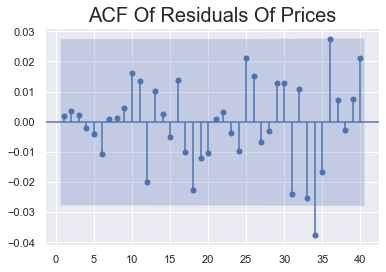

In [113]:
df['res_ar_5_ma_6'] = results_ar_5_ma_6.resid
sgt.plot_acf(df.res_ar_5_ma_6, zero = False, lags = 40)
plt.title("ACF Of Residuals Of Prices", size = 20)
plt.show()

##### NOTE - The residuals in the above graph resemble white noise.

In [114]:
print("\n ARMA(5,6): \tLL = ", results_ar_5_ma_6.llf, "\tAIC = ", results_ar_5_ma_6.aic)
print("\n ARMA(5,1): \tLL = ",results_ret_ar_5_ma_1.llf, "\tAIC = ", results_ret_ar_5_ma_1.aic)


 ARMA(5,6): 	LL =  -27582.864216673537 	AIC =  55191.728433347074

 ARMA(5,1): 	LL =  -7888.205977425261 	AIC =  15792.411954850522


##### NOTE - From above information, we can conclude that even though we can model prices using ARMA models, they perform much worse compared to their ability to estimate stationary data.